<a href="https://colab.research.google.com/github/VishwasMore/face-detection/blob/main/Face_Detection_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Facial Keypoint Detection 

## Load and Visualize Data

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [4]:
key_pts_frame = pd.read_csv('drive/My Drive/face/data/training_frames_keypoints.csv')

n = 0

image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts.shape)

(136,)


In [5]:
key_pts = key_pts.astype('float').reshape(-1, 2)
print(key_pts.shape)

(68, 2)


In [6]:
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [7]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


### Visualize some images

In [9]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [10]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts)

[45.0 98.0 47.0 106.0 49.0 110.0 53.0 119.0 56.0 125.0 62.0 130.0 66.0
 134.0 73.0 136.0 81.0 139.0 92.0 134.0 96.0 130.0 98.0 126.0 102.0 120.0
 102.0 111.0 104.0 105.0 104.0 99.0 102.0 90.0 51.0 89.0 56.0 87.0 60.0
 87.0 64.0 87.0 68.0 87.0 83.0 85.0 87.0 83.0 92.0 81.0 96.0 81.0 100.0
 84.0 77.0 92.0 79.0 98.0 79.0 102.0 79.0 107.0 73.0 109.0 75.0 109.0 79.0
 111.0 81.0 109.0 83.0 109.0 58.0 94.0 62.0 92.0 64.0 92.0 68.0 92.0 66.0
 94.0 62.0 94.0 85.0 92.0 87.0 90.0 92.0 90.0 94.0 90.0 92.0 92.0 87.0
 92.0 68.0 119.0 73.0 117.0 77.0 115.0 79.0 117.0 81.0 115.0 85.0 117.0
 90.0 117.0 87.0 122.0 85.0 124.0 81.0 124.0 77.0 124.0 73.0 121.0 70.0
 119.0 77.0 119.0 79.0 119.0 83.0 119.0 90.0 117.0 83.0 119.0 81.0 122.0
 77.0 122.0]


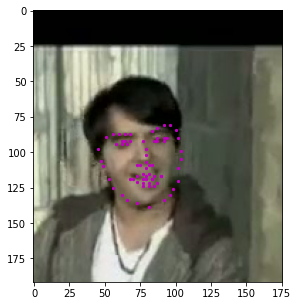

In [12]:
key_pts = key_pts.astype('float').reshape(-1,2)
plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('drive/My Drive/face/data/training/', image_name)), key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.

In [15]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
  """Face Landmarks dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    """
    Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.key_pts_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.key_pts_frame)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.root_dir, 
                              self.key_pts_frame.iloc[idx, 0])
    
    image = mpimg.imread(image_name)

    # if image has an alpha color channel, get rid of it
    if(image.shape[2] == 4):
            image = image[:,:,0:3]
    
    key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
    key_pts = key_pts.astype('float').reshape(-1, 2)
    sample = {'image': image, 'keypoints': key_pts}
    
    if self.transform:
            sample = self.transform(sample)
    
    return sample

In [16]:
# Now that we've defined this class, let's instantiate the dataset and display some images.

face_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/training_frames_keypoints.csv',
                                      root_dir='drive/My Drive/face/data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (103, 99, 3) (68, 2)
1 (240, 277, 3) (68, 2)
2 (179, 175, 3) (68, 2)


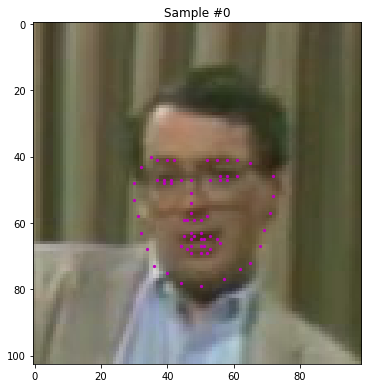

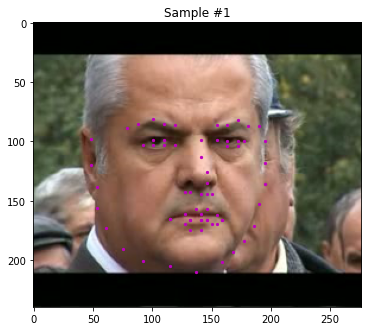

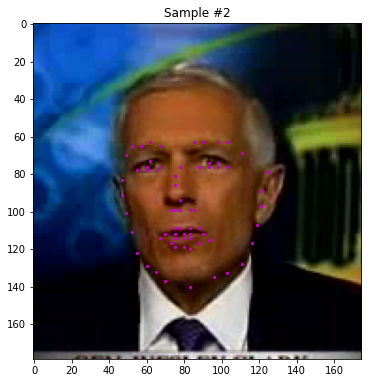

In [17]:
# Display few images of the dataset 

num_to_display = 3

for i in range(num_to_display):

  # define the size of image 
  fig = plt.figure(figsize=(20,10))

  # randomly select a sample
  rand_i = np.random.randint(0, len(face_dataset))
  sample = face_dataset[rand_i]

  # print the shape of the image and keypoints 
  print(i, sample['image'].shape, sample['keypoints'].shape)

  ax = plt.subplot(1, num_to_display, i + 1)
  ax.set_title('Sample #{}'.format(i))

  # Using the same display function, defined earlier
  show_keypoints(sample['image'], sample['keypoints'])

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.

In [19]:
import torch 
from torchvision import transforms, utils

class Normalize(object):
  """Convert a color image to grayscale and normalize the color range to [0,1]."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    # convert image to grayscale 
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale color range from [0, 255] to [0, 1]
    image_copy=  image_copy/255.0

    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    key_pts_copy = (key_pts_copy - 100)/50.0

    return {'image': image_copy, 'keypoints': key_pts_copy}

class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}